In [1]:
from sdRDM.generator import generate_python_api
import numpy as np

In [2]:
# generate_python_api("specifications/photometry.md", "", "PlateHandler")

In [3]:
%reload_ext autoreload
%autoreload 2

from PlateHandler.core.plate import Plate

# Load time-course data and create a ```Plate``` object


In [4]:
path = "/Users/max/Documents/enzymeml/alaric/EnzymeML_SLAC_5xConcentration_pH2.0-3.5/ABTS_EnzymeML_340nm_420nm_5x_35deg_pH3.5.txt"

time = np.linspace(0, 15, 31)

plate = Plate.from_file(path, time, "min", ph=3.5, temperature=35)

# Define Species, that are present across different wells

Each time a ```Well``` is created, a ```Species``` of the type 'buffer' is added to it.

In [5]:
buffer = plate.add_to_species(type="buffer", name="buffer", id="b0")
enzyme = plate.add_to_species(type="enzyme", name="SLAC", id="p0")
substrate = plate.add_to_species(type="substrate", name="ABTS", id="s0")

### Assign initial concentrations to different wells

In order to blank the data, we need to assign initial concentrations to the wells. Currently, initial conditions can be added per species, whereas different concentrations can be assigned to an entire row. If a s species is not present in the specified row, its concentration should be set to zero.

In [6]:
# Define buffer concentration
plate.assign_species_conditions_to_rows(
    row_ids=["A", "B", "C", "D", "E", "F"],
    species=buffer,
    init_concs=100,
    conc_unit="mM"
)

# Define substrate concentrations
plate.assign_species_conditions_to_rows(
    row_ids=["A", "B", "C", "D", "E", "F"],
    species=substrate,
    init_concs=[0, 5, 10, 15, 25, 50, 75, 100, 150, 200],
    conc_unit="mM"
)

# Define enzyme concentrations
plate.assign_species_conditions_to_rows(
    row_ids=["A", "B", "C"],
    species=enzyme,
    init_concs=4,
    conc_unit="nM"
)

### Blank data

Since we have assigned the initial concentrations for each species, blanking id carried out semi-automatically. By calling ```blank_species()```, the absorption contribution of the defined species is subtracted from all wells, in which the species is present.

__How does it work?__  
After specifying the concentration of each species present in each well for each well respectively, wells which were prepared for blanking are be implicitly identified.
If we call the blank function and specify a species which should be blanked, the blanking function first identifies wells which solely contain the specified species. Thereafter, the mean value across all identified wells for blanking is calculated. Thereafter, all wells which contain the selected species are selected and the calculated blank is subtracted from all absorption values. Lastly, a flag (```was_blanked = True```) is set, that prevents the species from being used for blanking again

In [7]:
plate.blank_species(buffer, 340)
plate.blank_species(enzyme, 340)

added D1, with condition length: 1 and [0] being b0
added E1, with condition length: 1 and [0] being b0
added F1, with condition length: 1 and [0] being b0
added A1, with condition length: 2 and [0] being p0
added B1, with condition length: 2 and [0] being p0
added C1, with condition length: 2 and [0] being p0


### Hand data to EnzymeML

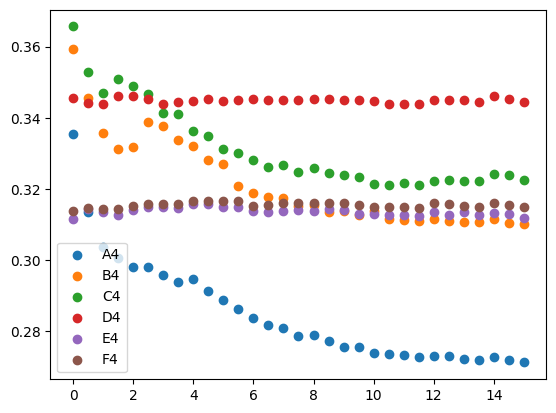

In [ ]:
# import matplotlib.pyplot as plt

# ids = ["A4", "B4", "C4", "D4", "E4", "F4"]

# wells = [well for well in plate.wells if well.id in ids and well.wavelength == 340]

# for well in wells:
#     plt.scatter(well.time, well.absorption, label=well.id)

# plt.legend()

In [ ]:
parse -> assing conc -> blank -> true values